In [1]:
N_GENES: int = 10

In [2]:
import os
from pyprojroot.here import here
from tqdm.auto import trange, tqdm

import pandas as pd
import anndata as ad
import numpy as np

import pickle

from collections import defaultdict

import re

sys.path.insert(1, str(here('bin')))
from customPythonFunctions import load_shap_statistics

In [14]:
CELL_TYPES=["Mono", "T_CD4_Naive", "T_CD4_NonNaive", "T_CD8_Naive", "T_CD8_NonNaive", "B", "Plasma", "UTC", "ILC", "pDC", "DC"]
DISEASES = ['healthy', 'sepsis', 'CD', 'SLE', 'HIV', 'cirrhosis', 'RA', 'COVID']
diseases = np.array(['BRCA', 'CD', 'COPD', 'COVID', 'CRC', 'HBV', 'HIV', 'HNSCC', 'MS', 'NPC', 'PS', 'PSA', 'RA', 'SLE', 'UC', 'asthma', 'cirrhosis', 'flu', 'healthy', 'sepsis'])

In [16]:
def load_shap_statistics(
    cell_type: str = '',
    interactions: bool = False, 
    run_name: str = 'run1',
):
    if interactions:
        shap_type = 'shap_int'
    else:
        shap_type = 'shap'
    fname = here(f"inflammabucket_bkp/03_downstream_analysis/05_SHAP/results/04_shap/shap_vals/total_{run_name}_{cell_type}_{shap_type}_stats.npz")
    shap_stats = np.load(fname)
    return (
        shap_stats['mean_raw'],
        shap_stats['var_raw'],
        shap_stats['mean_abs'],
        shap_stats['var_abs'])

In [17]:
shap_per_cell_type ={}
for cell_type in CELL_TYPES:
    adata = ad.read_h5ad(here(f'inflammabucket_bkp/03_downstream_analysis/05_SHAP/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'), backed='r')
    symbols_df = pd.read_pickle(here('inflammabucket_bkp/03_downstream_analysis/04_selected_gene_list.pkl'))
    symbols_sorted = symbols_df.loc[adata.var_names].symbol.values
    perc_gene_expr = pd.read_csv(here('inflammabucket_bkp/03_downstream_analysis/05_SHAP/data/genes_expressing_cells.csv'))
    perc_gene_expr = perc_gene_expr.astype({'symbol': 'str', '% cells': 'float', 'CellType': 'category'})
    well_expressed_symbols = perc_gene_expr.query('`% cells` > 5 & CellType == @cell_type').symbol
    symbol_mask = symbols_sorted.isin(well_expressed_symbols)
    
    _, _, mean_abs, _ = load_shap_statistics(cell_type, interactions=False)
    filtered_shap = mean_abs[symbol_mask]
    genes = symbols_sorted[symbol_mask]
    disease = adata.obs.disease.cat.categories
    filtered_shap = pd.DataFrame(filtered_shap, index = genes, columns = disease)
    filtered_shap = filtered_shap.loc[:, DISEASES]
    print(filtered_shap.shape)
    shap_per_cell_type[cell_type]= filtered_shap


(612, 8)
(436, 8)
(492, 8)
(431, 8)
(520, 8)
(466, 8)
(592, 8)
(496, 8)
(506, 8)
(522, 8)
(649, 8)


In [6]:
top10_shap_per_cell_type = {}
top10_shap_values_per_cell_type = {}
for cell_type in CELL_TYPES:
    tmp = shap_per_cell_type[cell_type]
    highest_shap_values = {}
    highest_shaps = {}
    for disease in DISEASES:
        highest_shap = tmp.loc[:, disease].nlargest(5).to_frame()
        highest_shap_values[disease] = highest_shap
        highest_shaps[disease] = highest_shap.index
    top10_shap_per_cell_type[cell_type] = pd.DataFrame(highest_shaps)
    top10_shap_values_per_cell_type[cell_type] = highest_shap_values

In [18]:
selected_genes_per_cell_type = {}
for cell_type in CELL_TYPES:
    tmp = top10_shap_per_cell_type[cell_type]
    tmp = tmp.to_numpy().flatten()
    tmp = np.unique(tmp)
    selected_genes_per_cell_type[cell_type] = tmp

In [19]:
[(k, len(v)) for k,v in selected_genes_per_cell_type.items()]

[('Mono', 35),
 ('T_CD4_Naive', 31),
 ('T_CD4_NonNaive', 33),
 ('T_CD8_Naive', 31),
 ('T_CD8_NonNaive', 33),
 ('B', 29),
 ('Plasma', 30),
 ('UTC', 35),
 ('ILC', 29),
 ('pDC', 34),
 ('DC', 32)]

In [20]:
for cell_type in CELL_TYPES:
    selection = symbols_df.reset_index().set_index('symbol').loc[selected_genes_per_cell_type[cell_type]].ensembl_gene_id.values
    np.save(f'gene_subsets_{N_GENES}/{cell_type}_shap',selection)

In [21]:
for cell_type in CELL_TYPES:
    adata = ad.read_h5ad(here(f'inflammabucket_bkp/03_downstream_analysis/05_SHAP/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'), backed='r')
    symbols_df = pd.read_pickle(here('inflammabucket_bkp/03_downstream_analysis/04_selected_gene_list.pkl'))
    symbols_sorted = symbols_df.loc[adata.var_names].symbol.values
    perc_gene_expr = pd.read_csv(here('inflammabucket_bkp/03_downstream_analysis/05_SHAP/data/genes_expressing_cells.csv'))
    perc_gene_expr = perc_gene_expr.astype({'symbol': 'str', '% cells': 'float', 'CellType': 'category'})
    well_expressed_symbols = perc_gene_expr.query('`% cells` > 5 & CellType == @cell_type').symbol
    symbol_mask = symbols_sorted.isin(well_expressed_symbols)
    symbols_sorted = symbols_sorted[symbol_mask]

    target_sel_size = len(selected_genes_per_cell_type[cell_type])
    print(symbols_sorted.shape)
    symbols_sorted = symbols_sorted[~symbols_sorted.isin(selected_genes_per_cell_type[cell_type])]
    print(symbols_sorted.shape)

    for seed in range(100):
        rng = np.random.default_rng(seed)
        rand_sel = rng.choice(symbols_sorted, size=target_sel_size, replace=False)
        rand_sel = symbols_df.reset_index().set_index('symbol').loc[rand_sel].ensembl_gene_id.values
        assert len(np.unique(rand_sel)) == target_sel_size
        np.save(f'gene_subsets_{N_GENES}/{cell_type}_{seed}', rand_sel)

(612,)
(577,)
(436,)
(405,)
(492,)
(459,)
(431,)
(400,)
(520,)
(487,)
(466,)
(437,)
(592,)
(562,)
(496,)
(461,)
(506,)
(477,)
(522,)
(488,)
(649,)
(617,)


In [22]:
sel_size = {}
for cell_type in CELL_TYPES:
    adata = ad.read_h5ad(here(f'inflammabucket_bkp/03_downstream_analysis/05_SHAP/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'), backed='r')
    symbols_df = pd.read_pickle(here('inflammabucket_bkp/03_downstream_analysis/04_selected_gene_list.pkl'))
    symbols_sorted = symbols_df.loc[adata.var_names].symbol.values
    perc_gene_expr = pd.read_csv(here('inflammabucket_bkp/03_downstream_analysis/05_SHAP/data/genes_expressing_cells.csv'))
    perc_gene_expr = perc_gene_expr.astype({'symbol': 'str', '% cells': 'float', 'CellType': 'category'})
    well_expressed_symbols = perc_gene_expr.query('`% cells` > 5 & CellType == @cell_type').symbol
    symbol_mask = symbols_sorted.isin(well_expressed_symbols)

    sel_size[cell_type] = len(selected_genes_per_cell_type[cell_type]) / np.sum(symbol_mask)

In [23]:
pd.DataFrame.from_dict([sel_size]).T.to_csv(f'sel_percent_{N_GENES}.csv')

<Figure size 1500x1000 with 0 Axes>

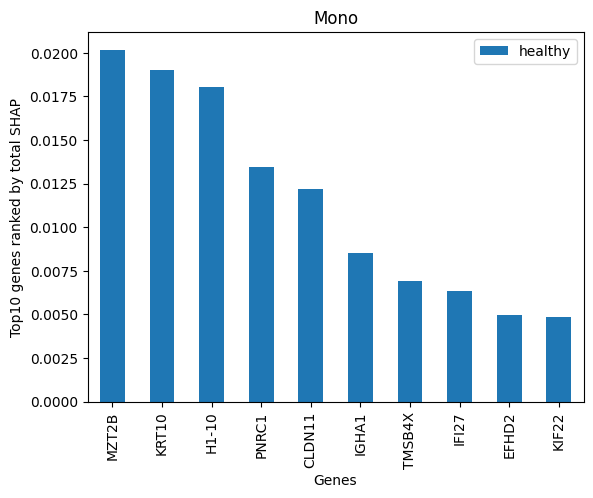

<Figure size 1500x1000 with 0 Axes>

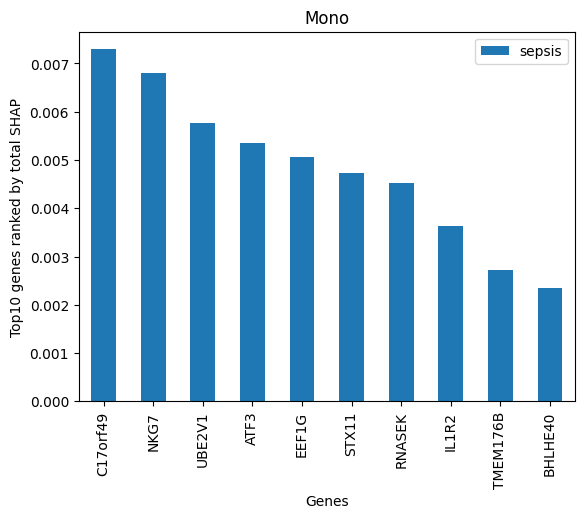

<Figure size 1500x1000 with 0 Axes>

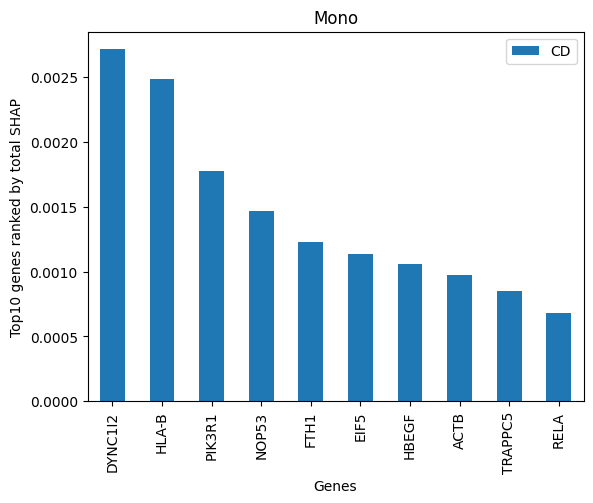

<Figure size 1500x1000 with 0 Axes>

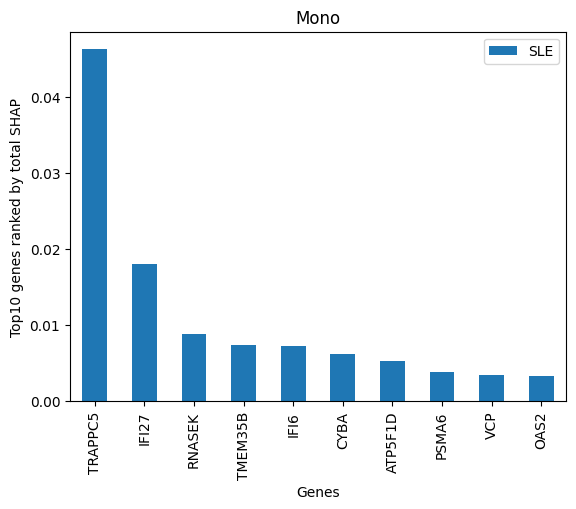

<Figure size 1500x1000 with 0 Axes>

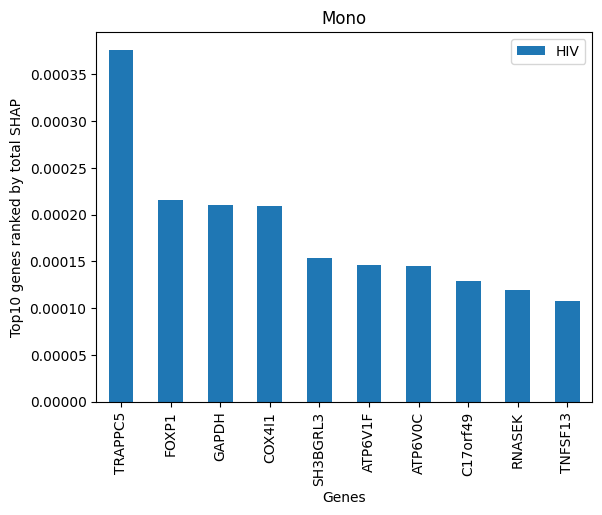

<Figure size 1500x1000 with 0 Axes>

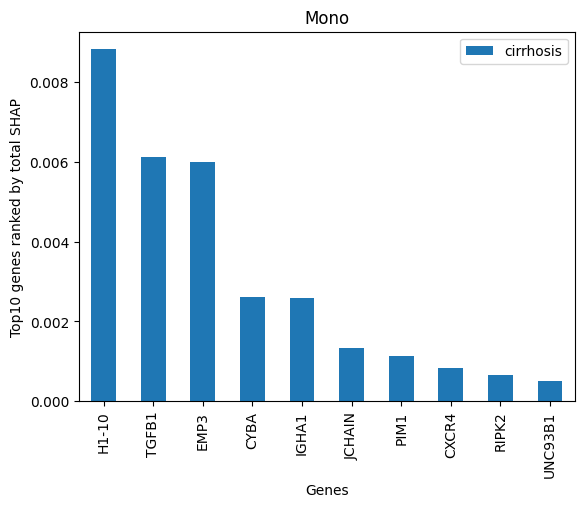

<Figure size 1500x1000 with 0 Axes>

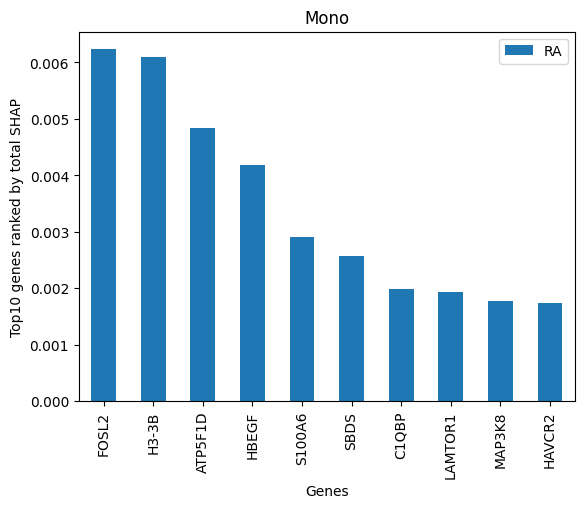

<Figure size 1500x1000 with 0 Axes>

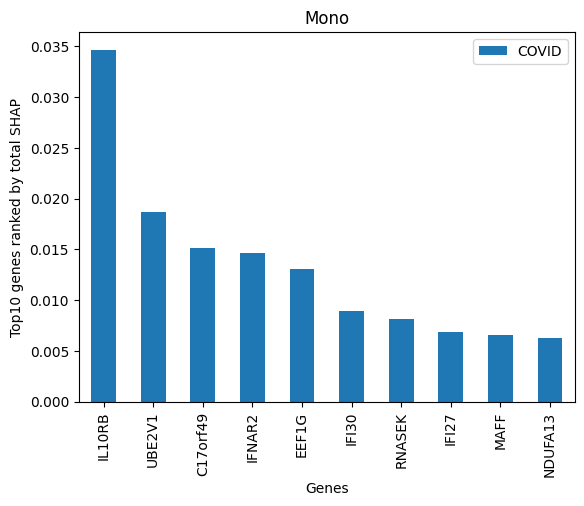

<Figure size 1500x1000 with 0 Axes>

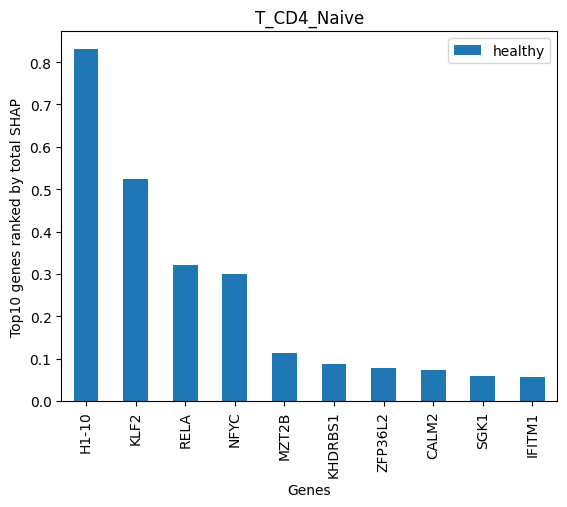

<Figure size 1500x1000 with 0 Axes>

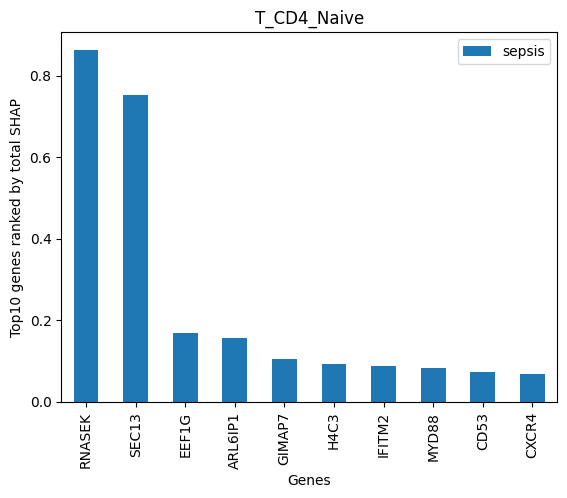

<Figure size 1500x1000 with 0 Axes>

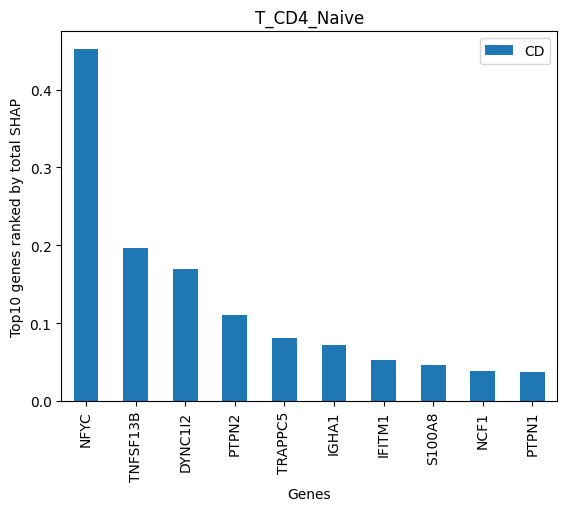

<Figure size 1500x1000 with 0 Axes>

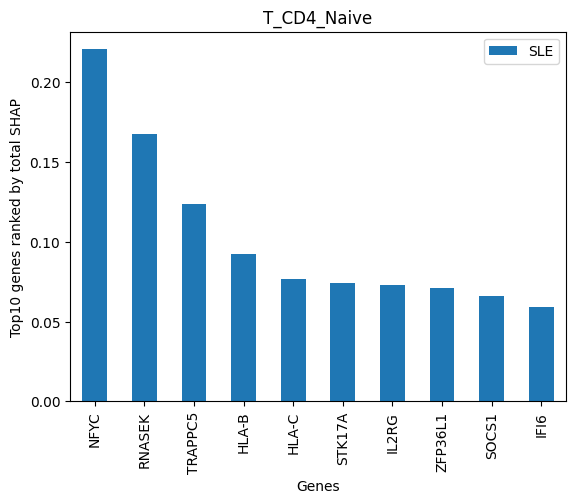

<Figure size 1500x1000 with 0 Axes>

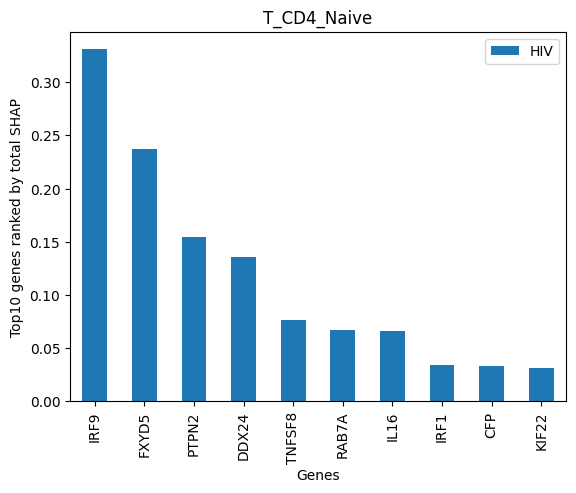

<Figure size 1500x1000 with 0 Axes>

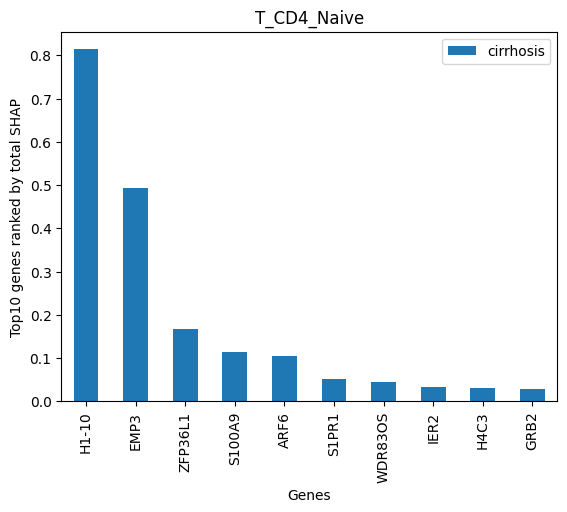

<Figure size 1500x1000 with 0 Axes>

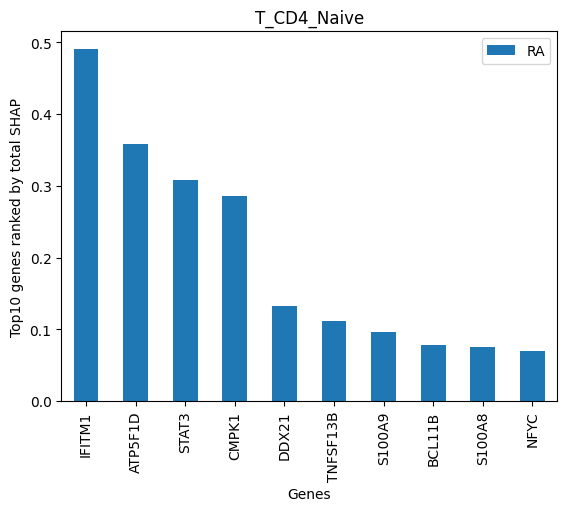

<Figure size 1500x1000 with 0 Axes>

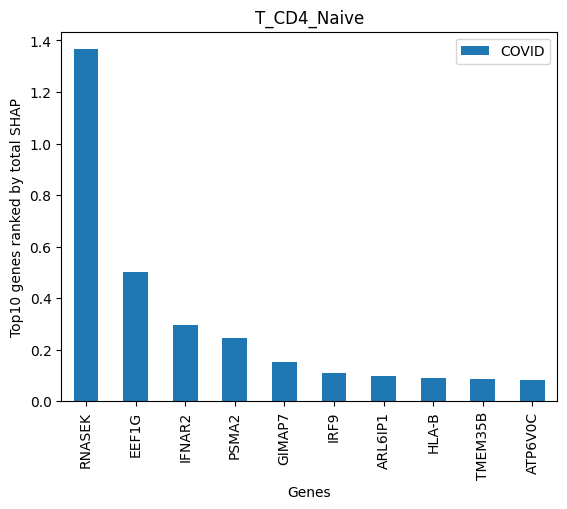

<Figure size 1500x1000 with 0 Axes>

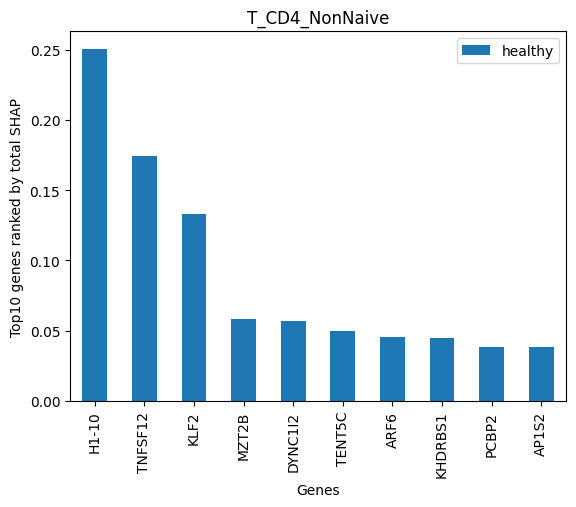

<Figure size 1500x1000 with 0 Axes>

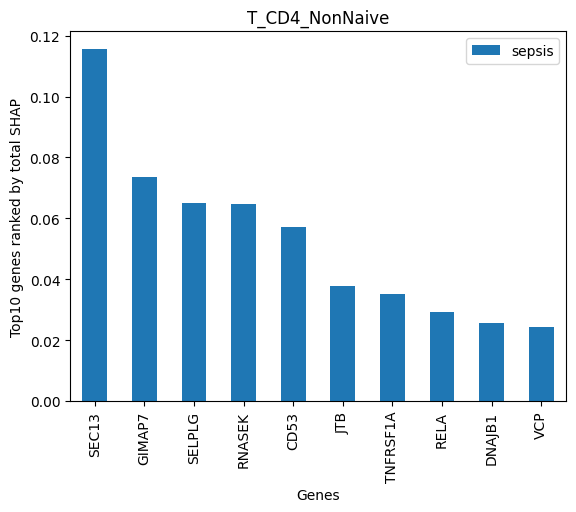

<Figure size 1500x1000 with 0 Axes>

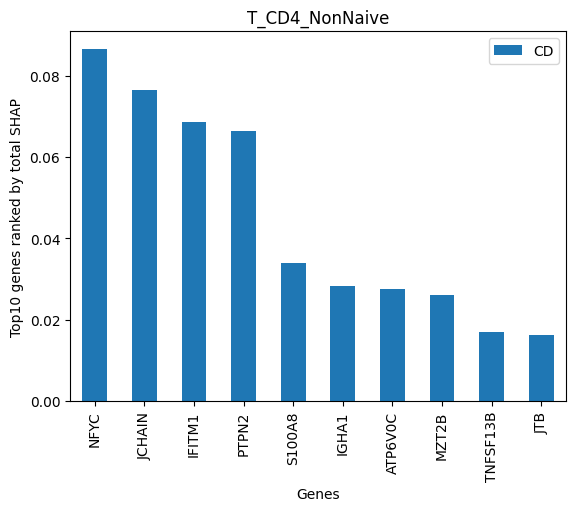

<Figure size 1500x1000 with 0 Axes>

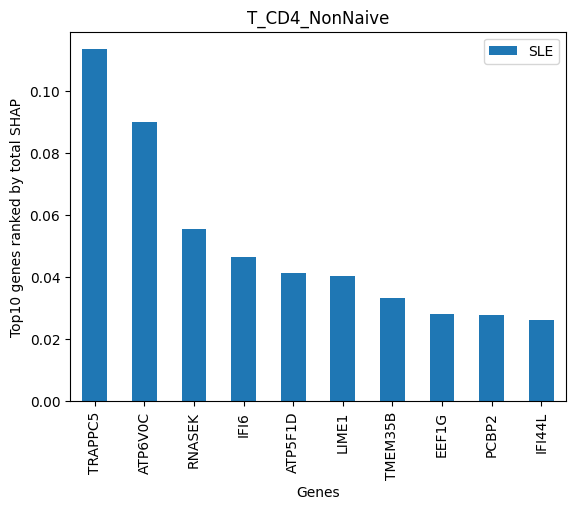

<Figure size 1500x1000 with 0 Axes>

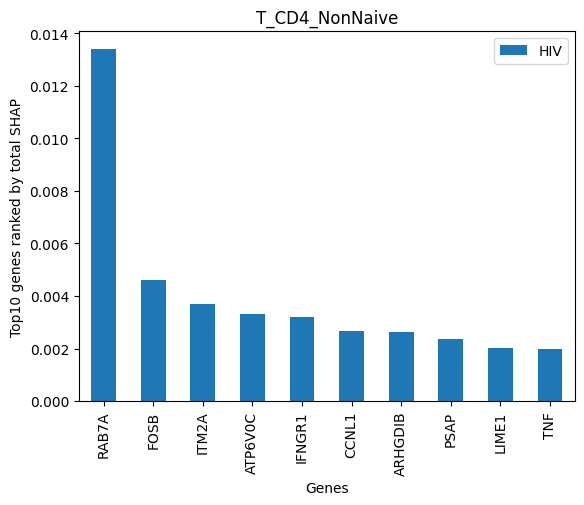

<Figure size 1500x1000 with 0 Axes>

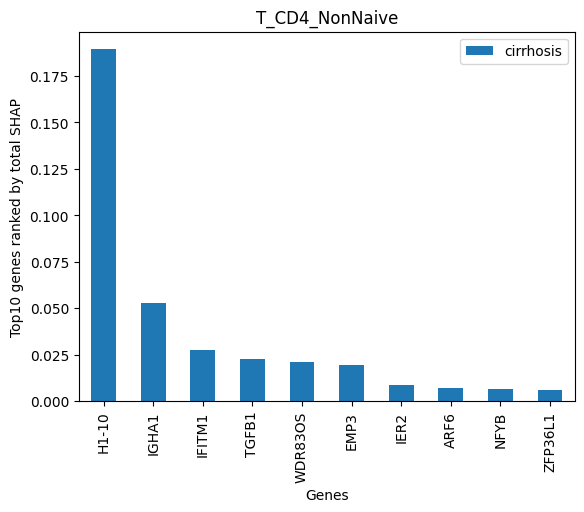

<Figure size 1500x1000 with 0 Axes>

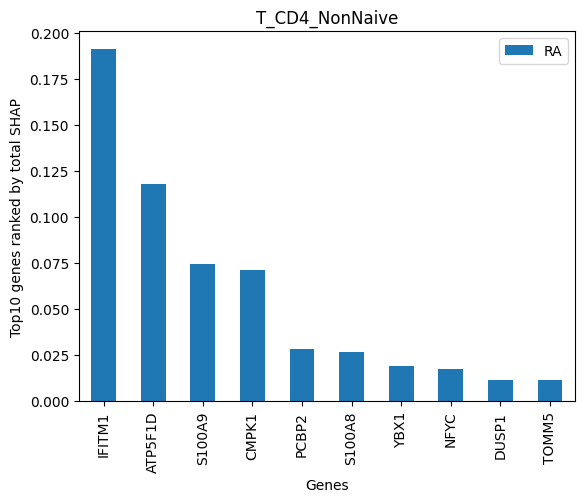

<Figure size 1500x1000 with 0 Axes>

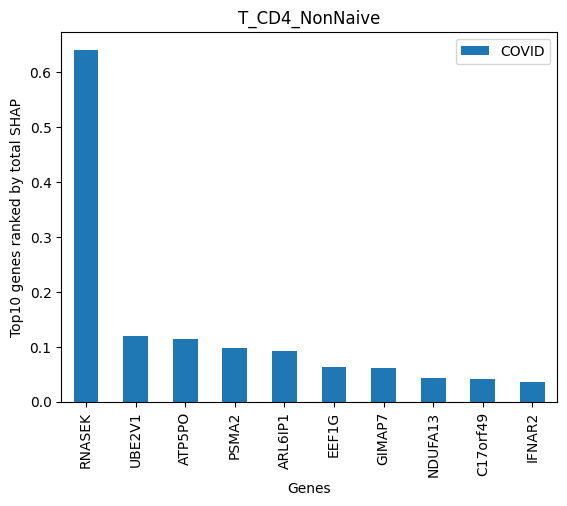

<Figure size 1500x1000 with 0 Axes>

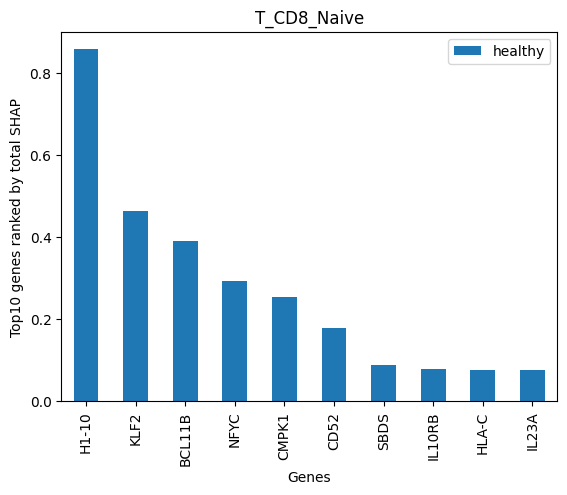

<Figure size 1500x1000 with 0 Axes>

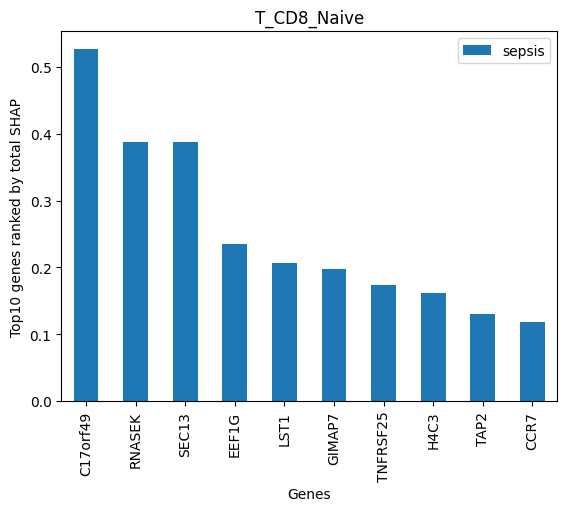

<Figure size 1500x1000 with 0 Axes>

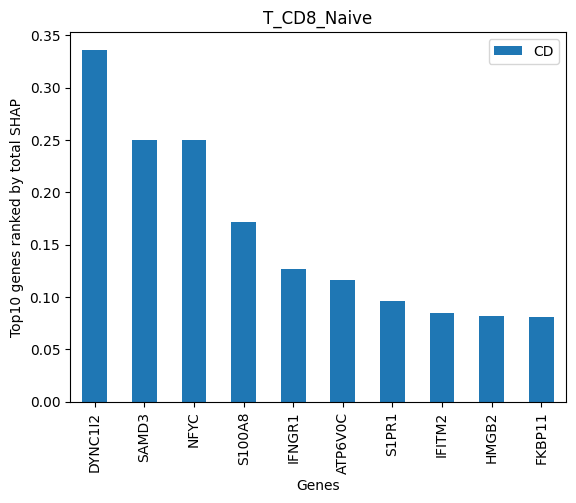

<Figure size 1500x1000 with 0 Axes>

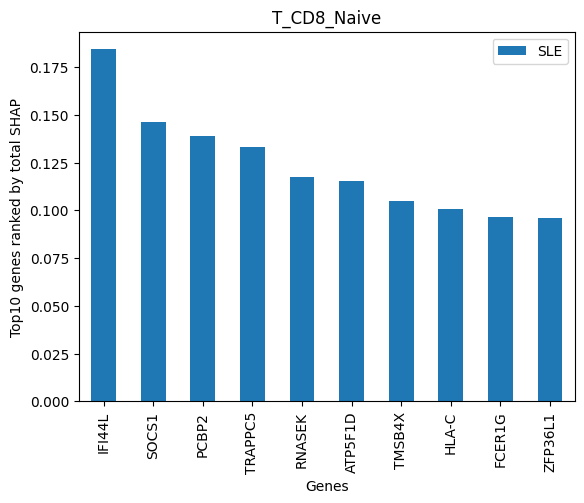

<Figure size 1500x1000 with 0 Axes>

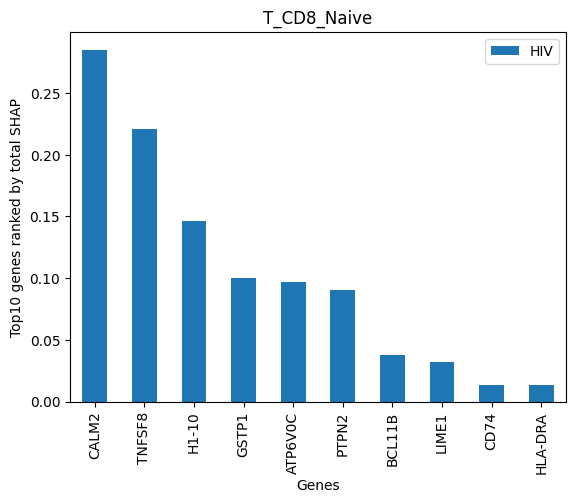

<Figure size 1500x1000 with 0 Axes>

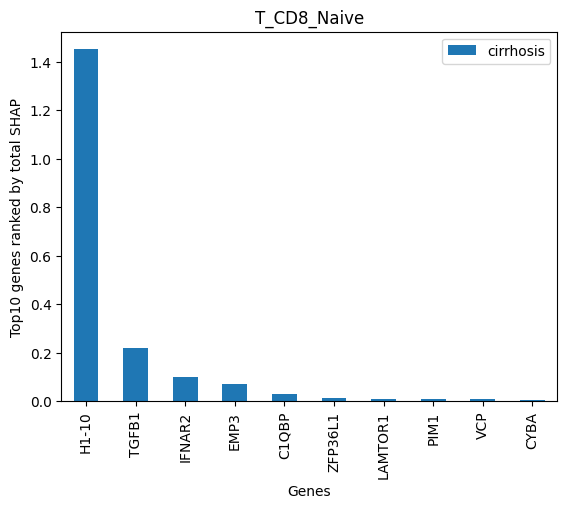

<Figure size 1500x1000 with 0 Axes>

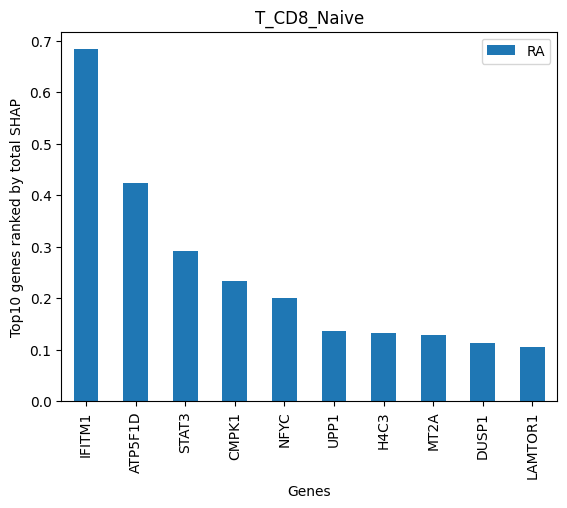

<Figure size 1500x1000 with 0 Axes>

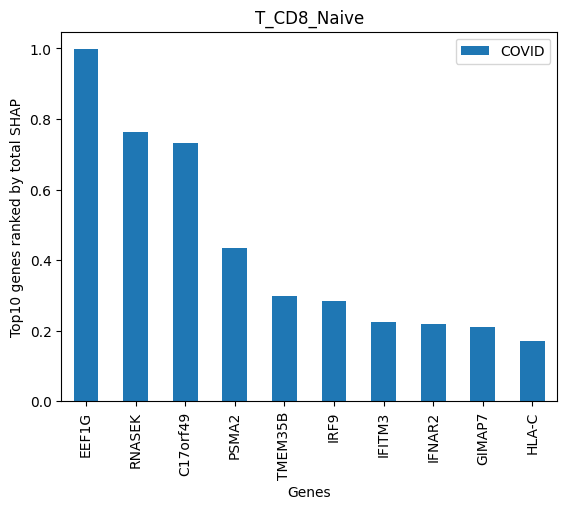

<Figure size 1500x1000 with 0 Axes>

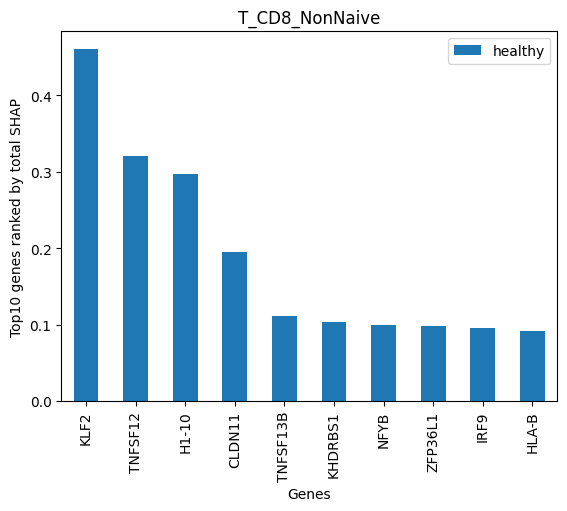

<Figure size 1500x1000 with 0 Axes>

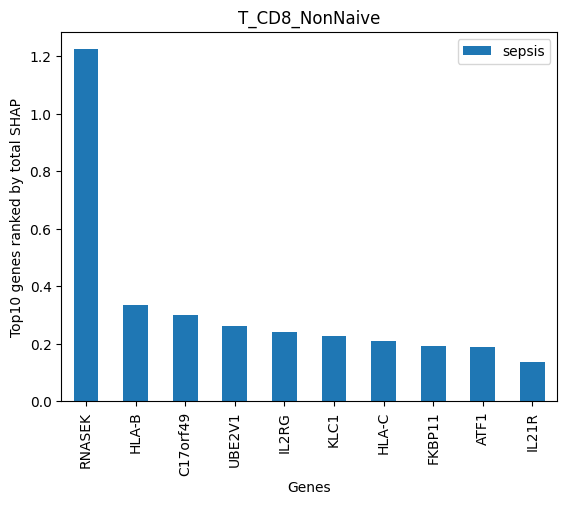

<Figure size 1500x1000 with 0 Axes>

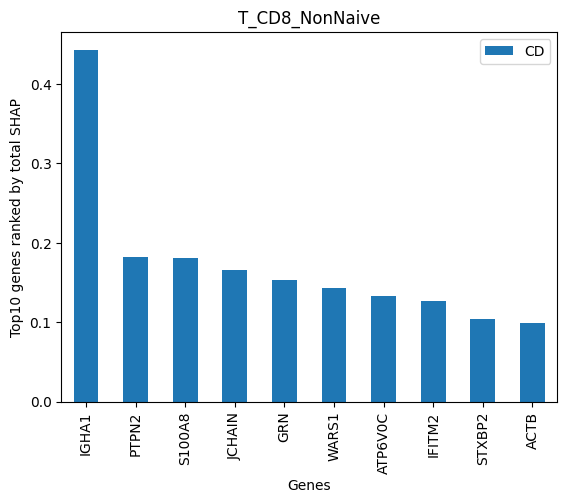

<Figure size 1500x1000 with 0 Axes>

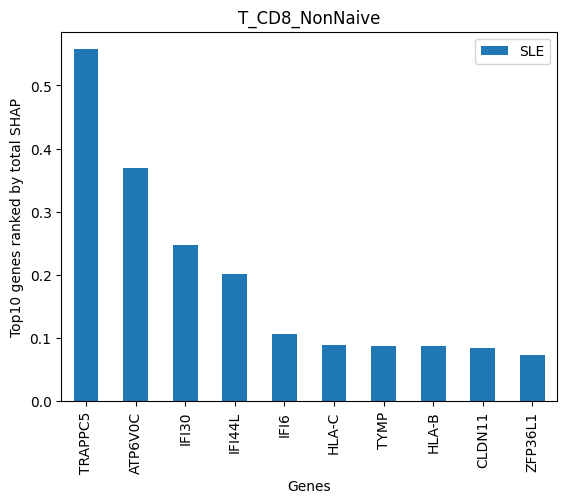

<Figure size 1500x1000 with 0 Axes>

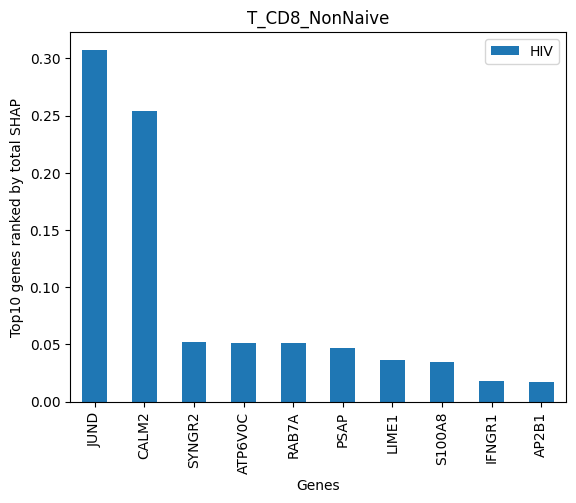

<Figure size 1500x1000 with 0 Axes>

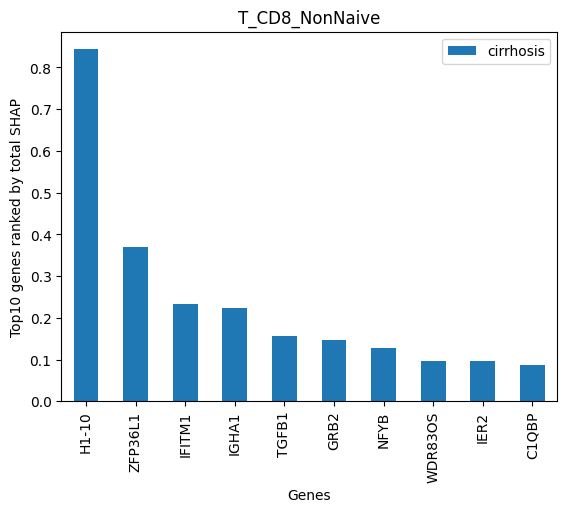

<Figure size 1500x1000 with 0 Axes>

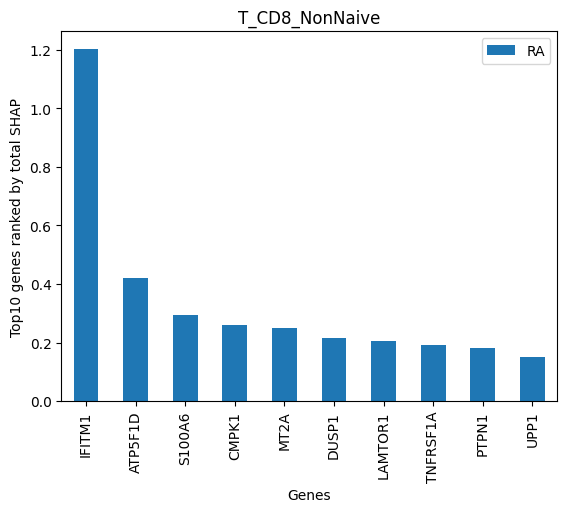

<Figure size 1500x1000 with 0 Axes>

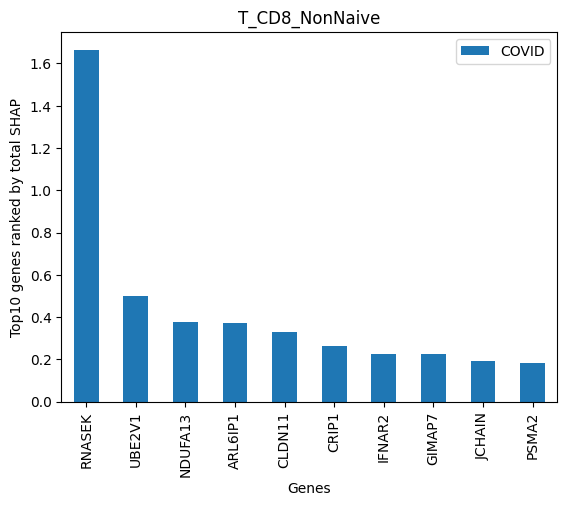

<Figure size 1500x1000 with 0 Axes>

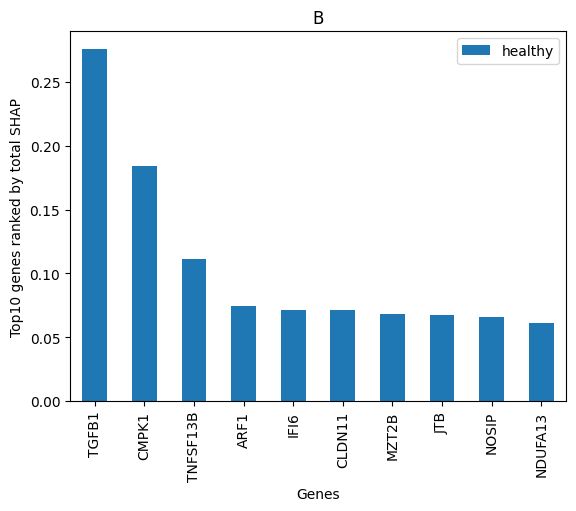

<Figure size 1500x1000 with 0 Axes>

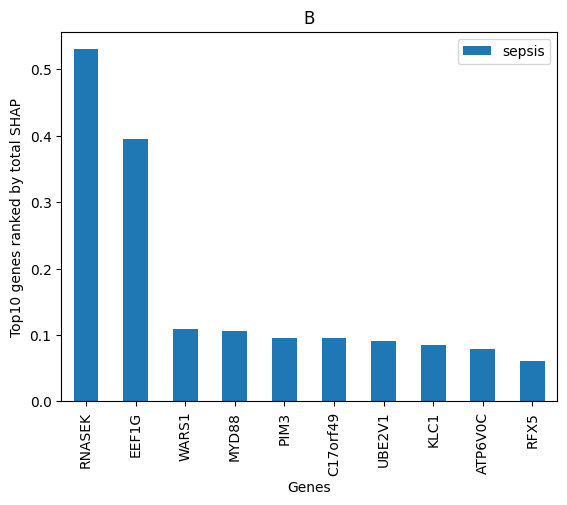

<Figure size 1500x1000 with 0 Axes>

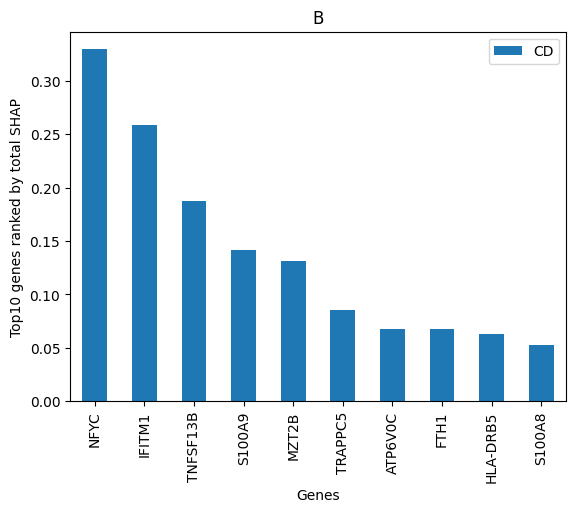

<Figure size 1500x1000 with 0 Axes>

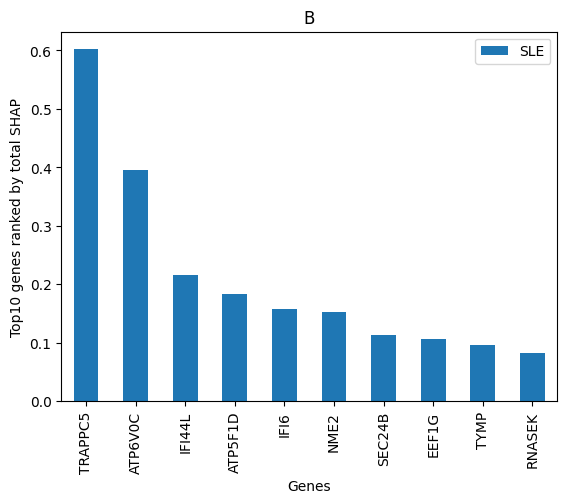

<Figure size 1500x1000 with 0 Axes>

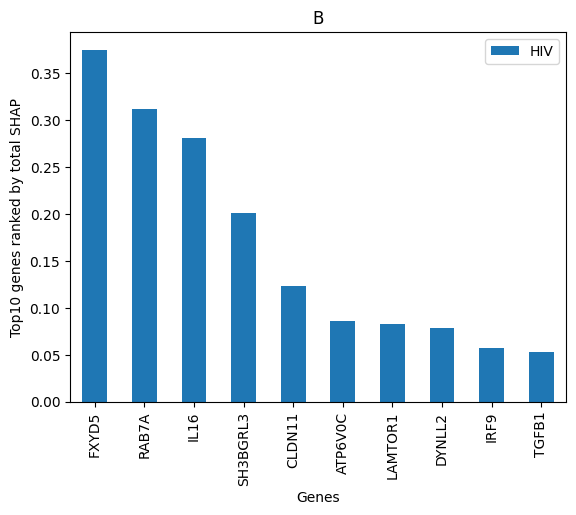

<Figure size 1500x1000 with 0 Axes>

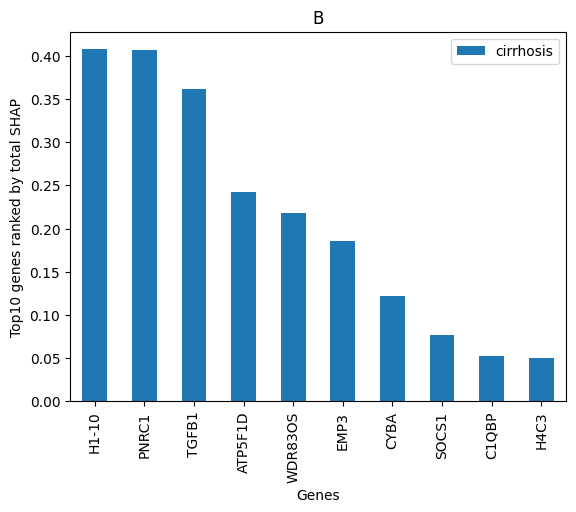

<Figure size 1500x1000 with 0 Axes>

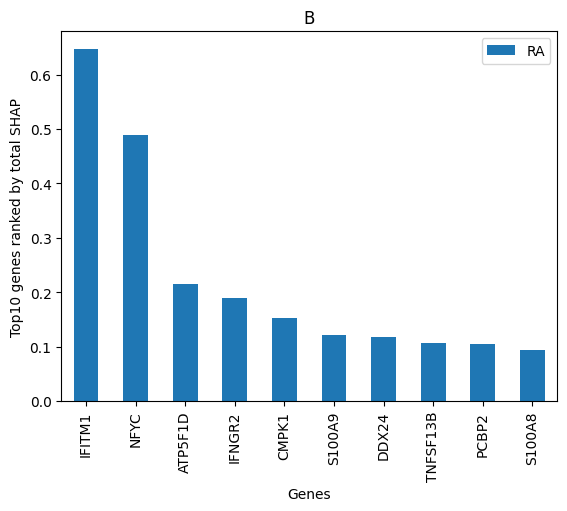

<Figure size 1500x1000 with 0 Axes>

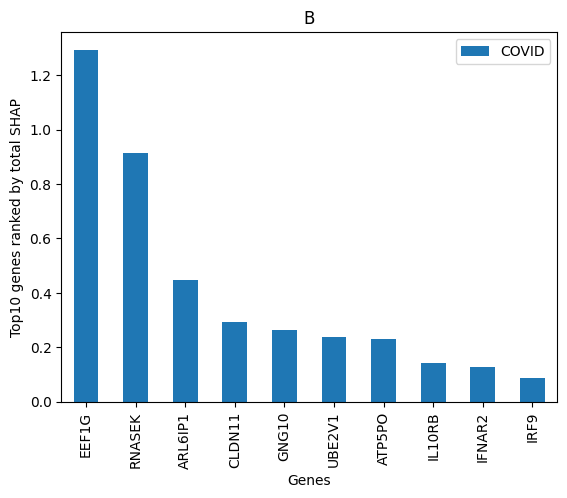

<Figure size 1500x1000 with 0 Axes>

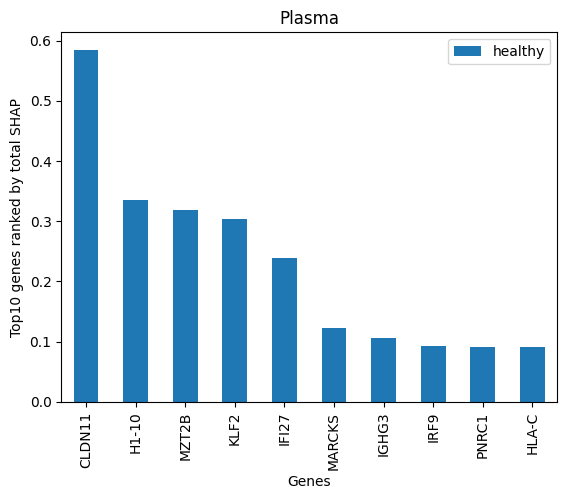

<Figure size 1500x1000 with 0 Axes>

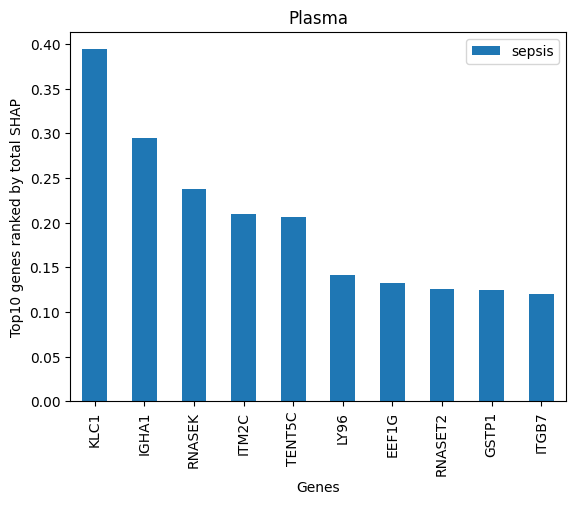

<Figure size 1500x1000 with 0 Axes>

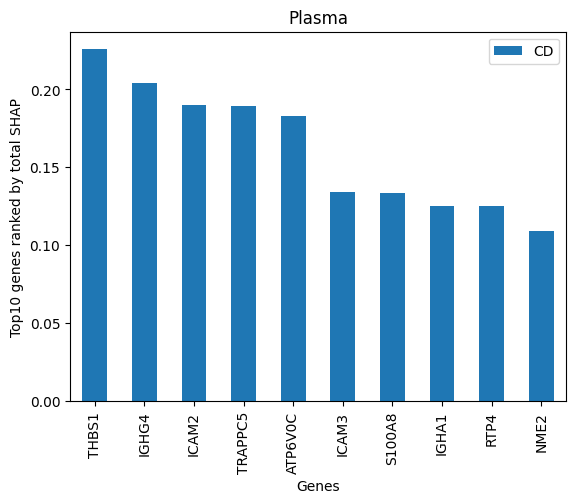

<Figure size 1500x1000 with 0 Axes>

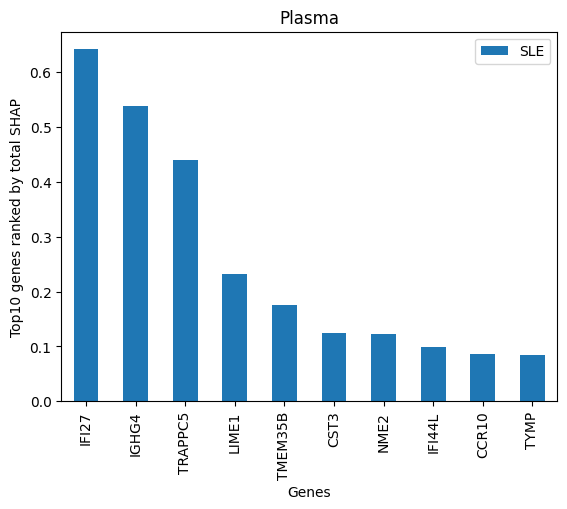

<Figure size 1500x1000 with 0 Axes>

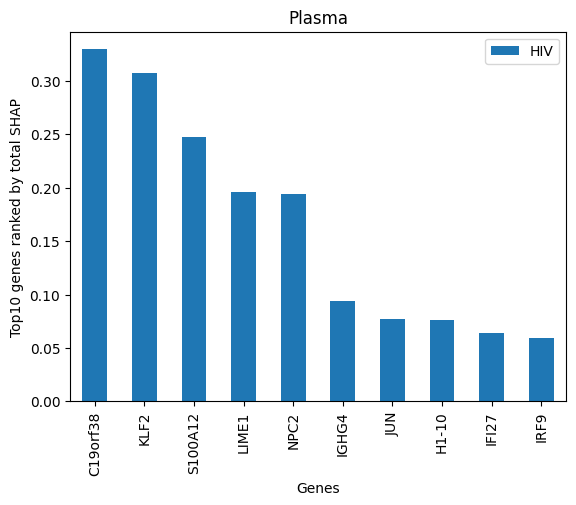

<Figure size 1500x1000 with 0 Axes>

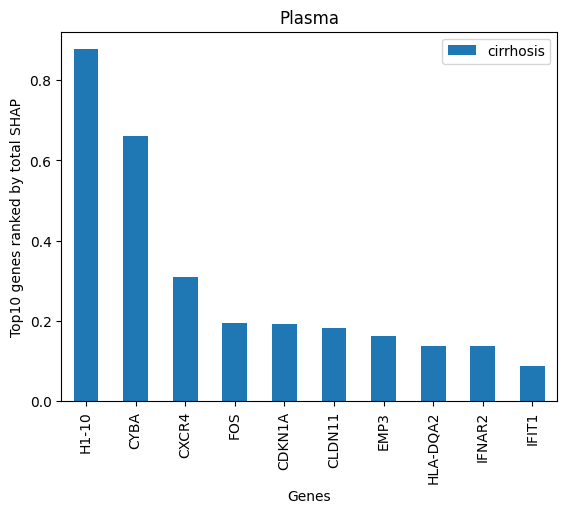

<Figure size 1500x1000 with 0 Axes>

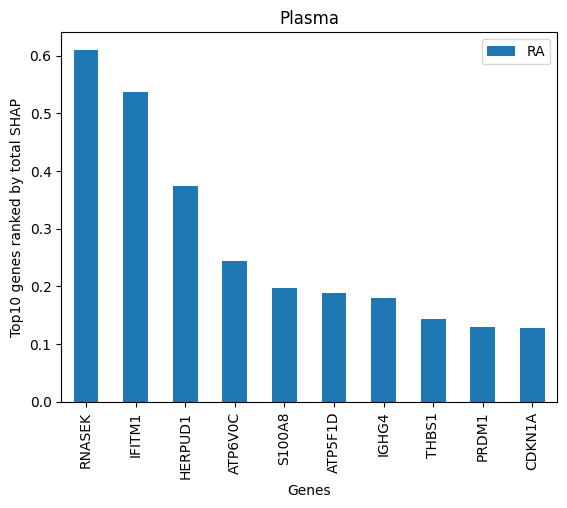

<Figure size 1500x1000 with 0 Axes>

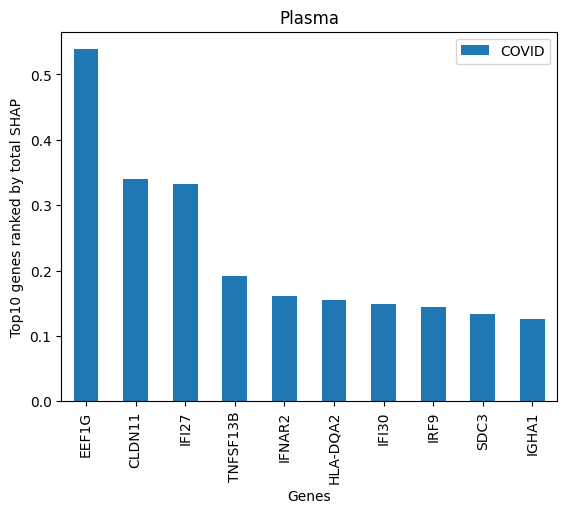

<Figure size 1500x1000 with 0 Axes>

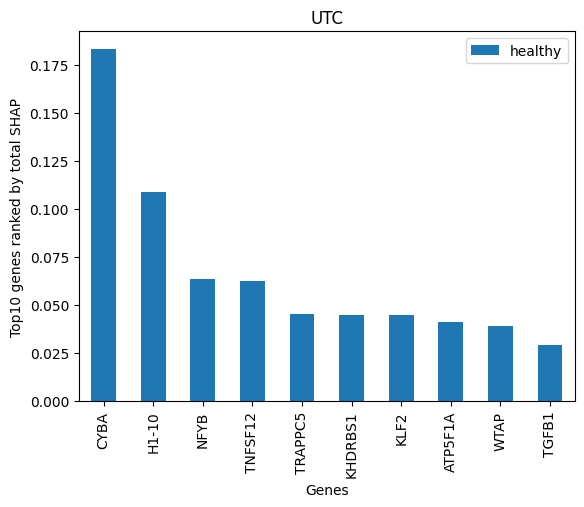

<Figure size 1500x1000 with 0 Axes>

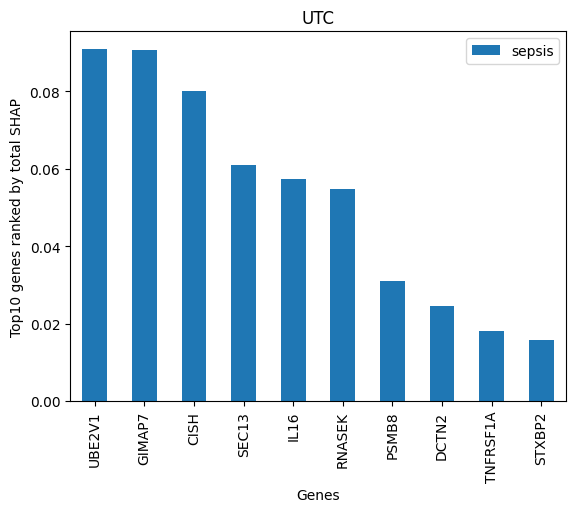

<Figure size 1500x1000 with 0 Axes>

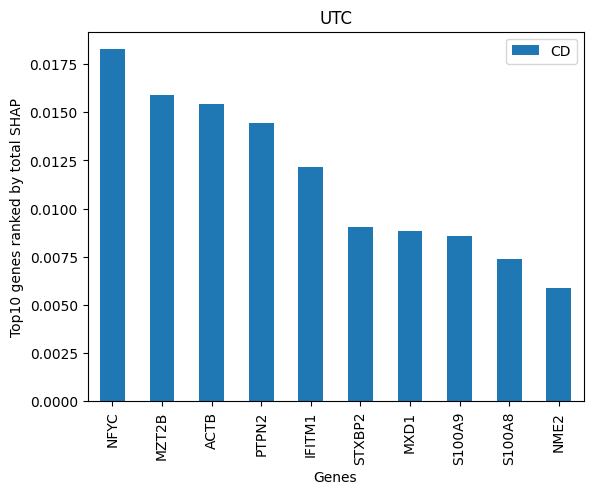

<Figure size 1500x1000 with 0 Axes>

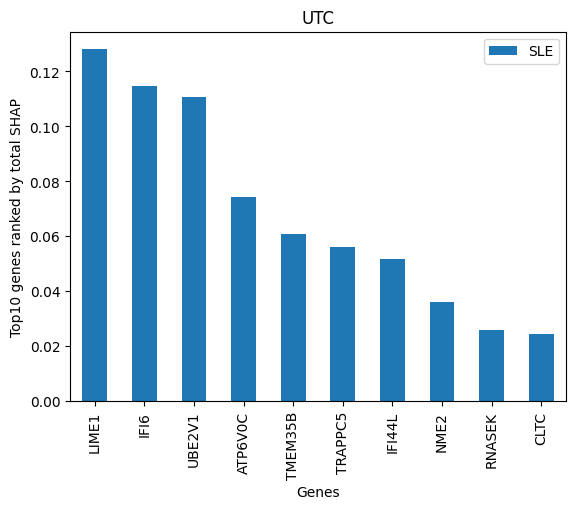

<Figure size 1500x1000 with 0 Axes>

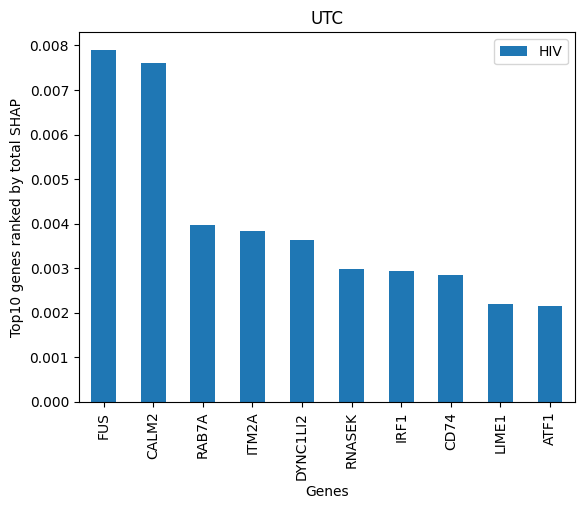

<Figure size 1500x1000 with 0 Axes>

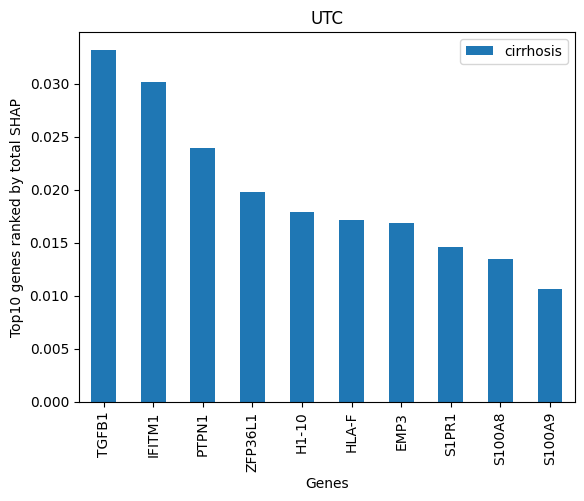

<Figure size 1500x1000 with 0 Axes>

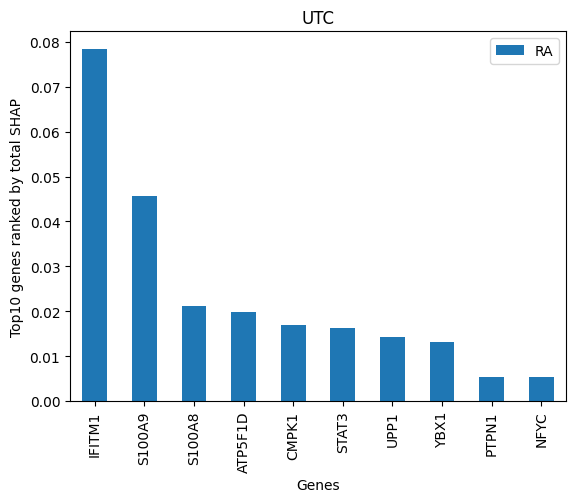

<Figure size 1500x1000 with 0 Axes>

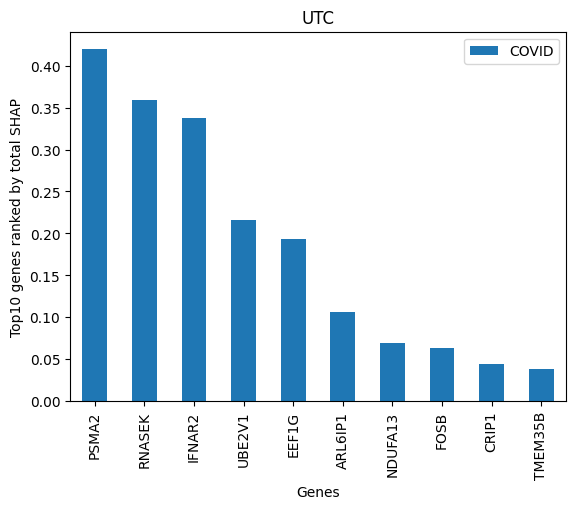

<Figure size 1500x1000 with 0 Axes>

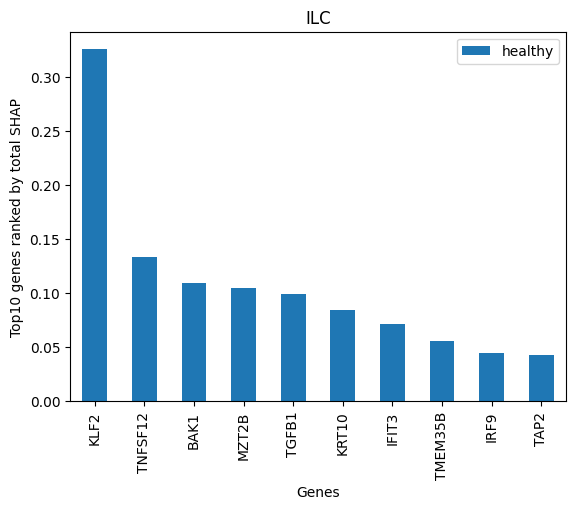

<Figure size 1500x1000 with 0 Axes>

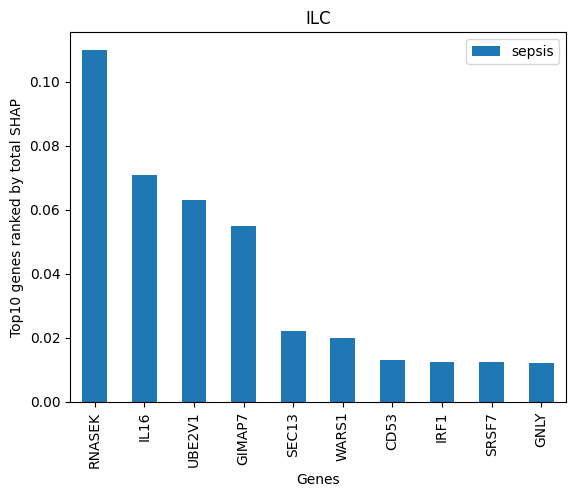

<Figure size 1500x1000 with 0 Axes>

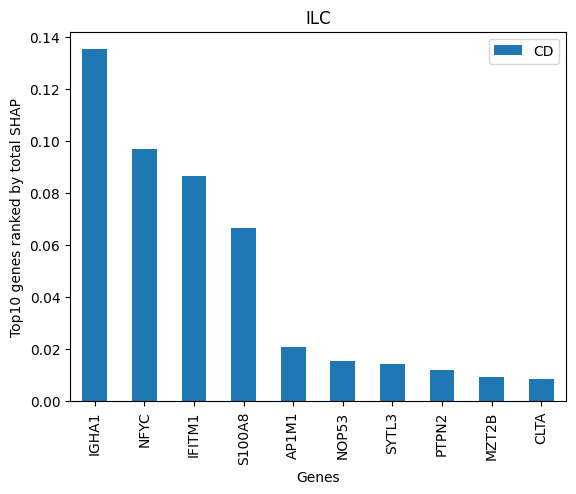

<Figure size 1500x1000 with 0 Axes>

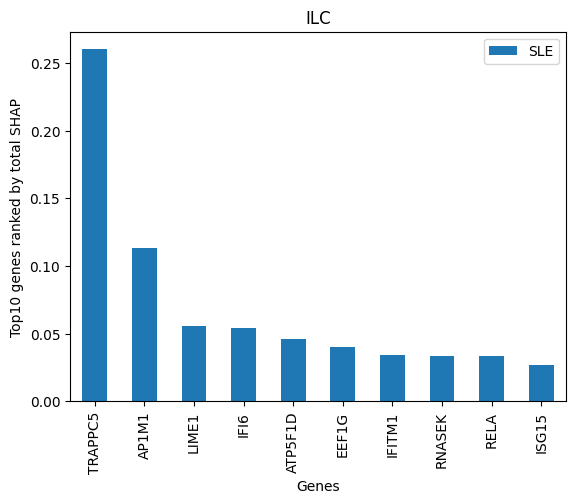

<Figure size 1500x1000 with 0 Axes>

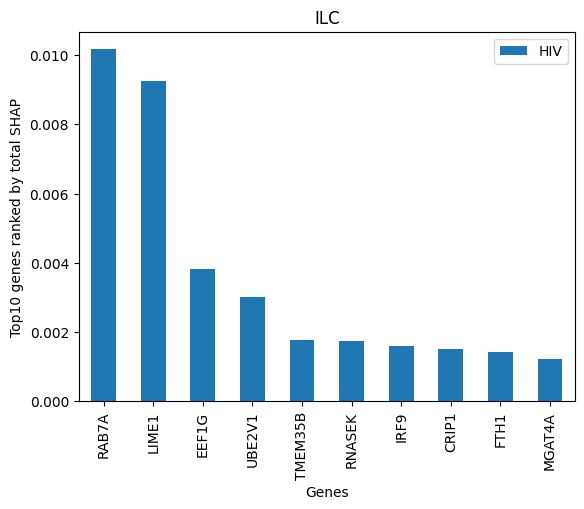

<Figure size 1500x1000 with 0 Axes>

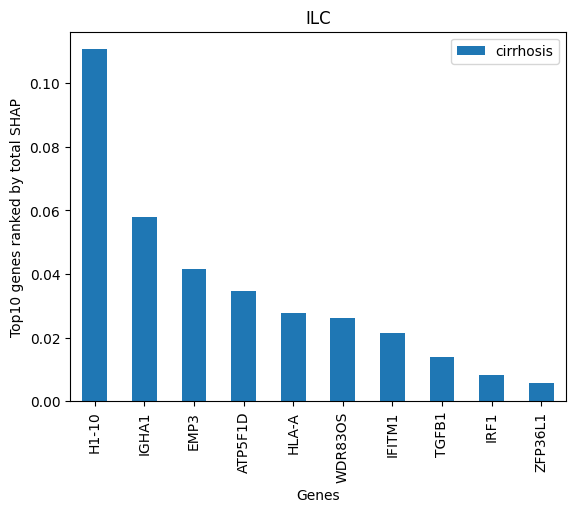

<Figure size 1500x1000 with 0 Axes>

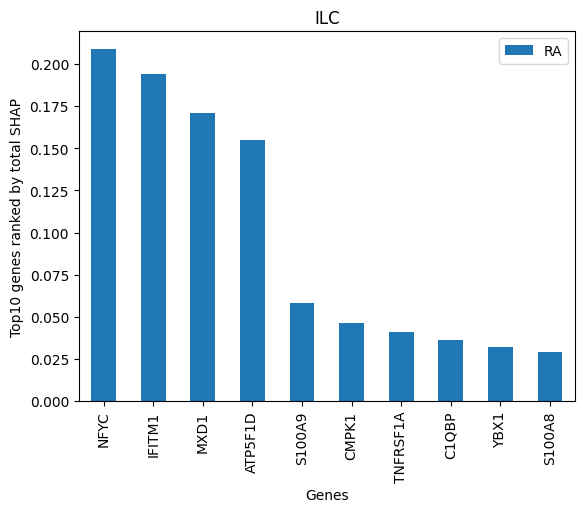

<Figure size 1500x1000 with 0 Axes>

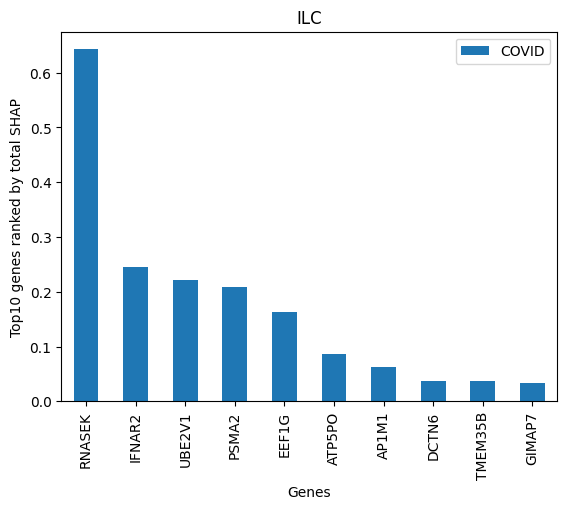

<Figure size 1500x1000 with 0 Axes>

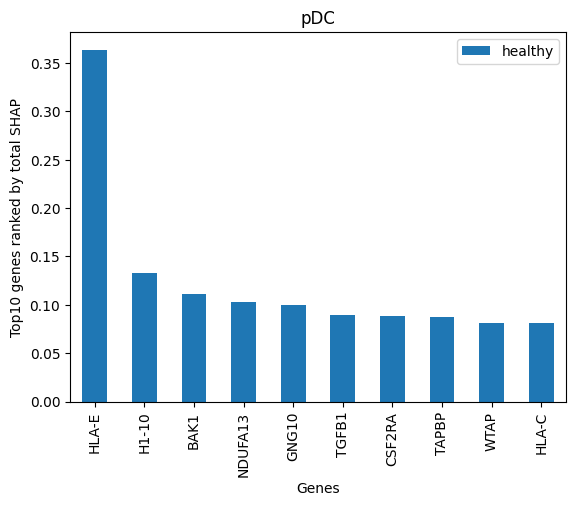

<Figure size 1500x1000 with 0 Axes>

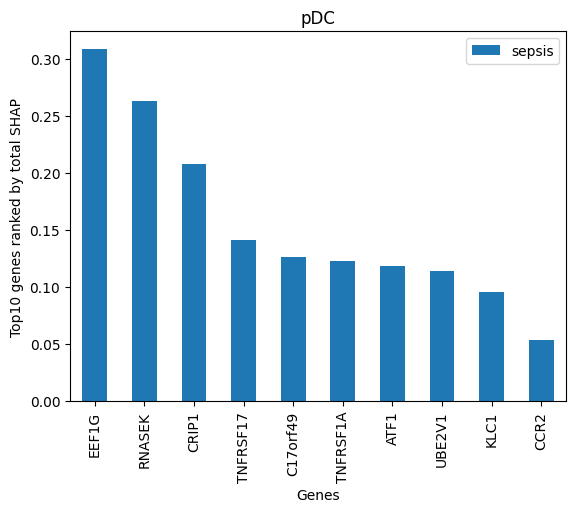

<Figure size 1500x1000 with 0 Axes>

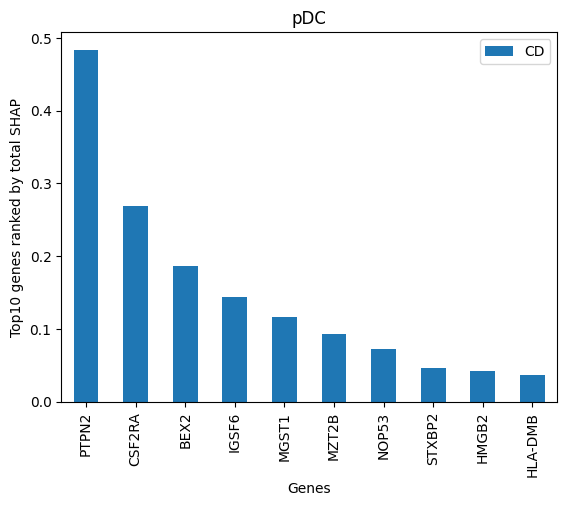

<Figure size 1500x1000 with 0 Axes>

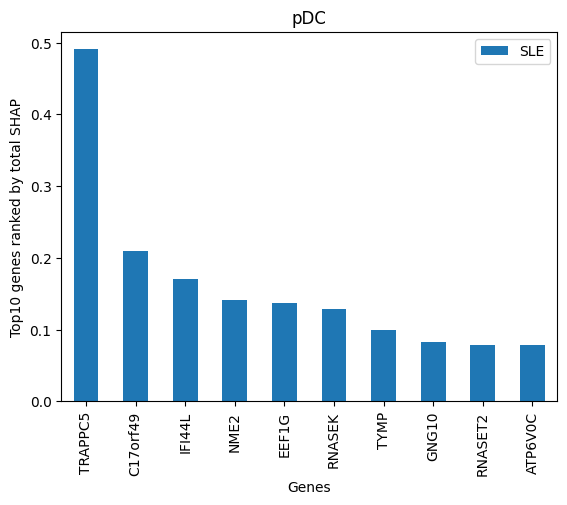

<Figure size 1500x1000 with 0 Axes>

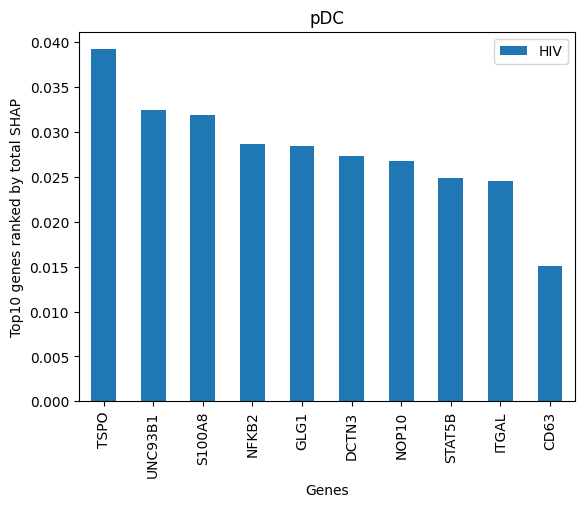

<Figure size 1500x1000 with 0 Axes>

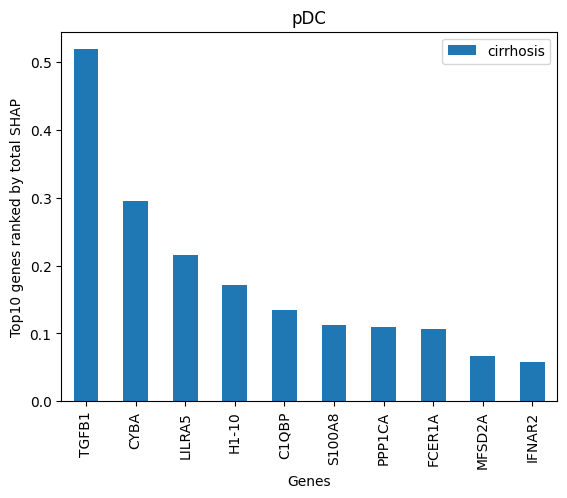

<Figure size 1500x1000 with 0 Axes>

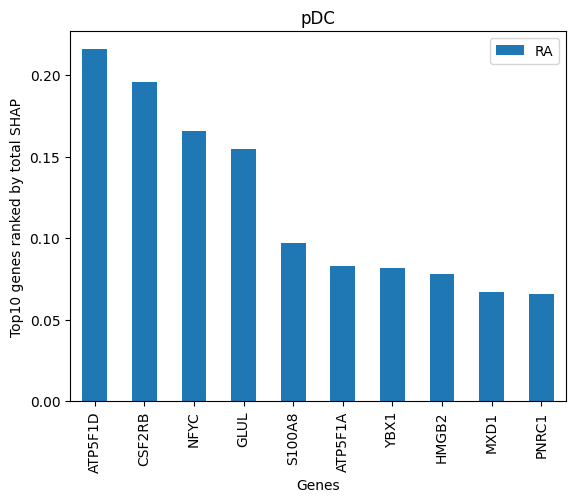

<Figure size 1500x1000 with 0 Axes>

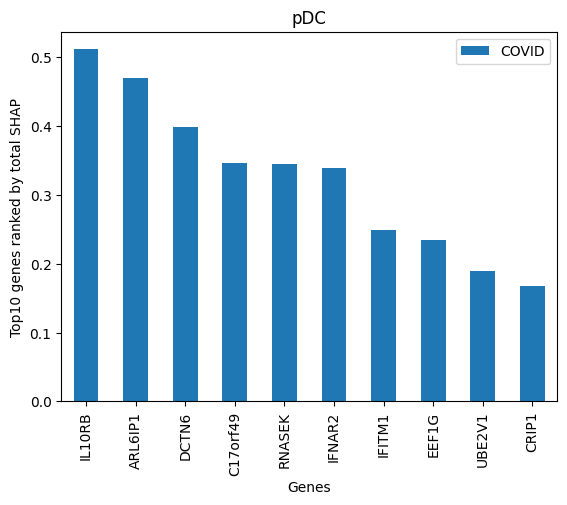

<Figure size 1500x1000 with 0 Axes>

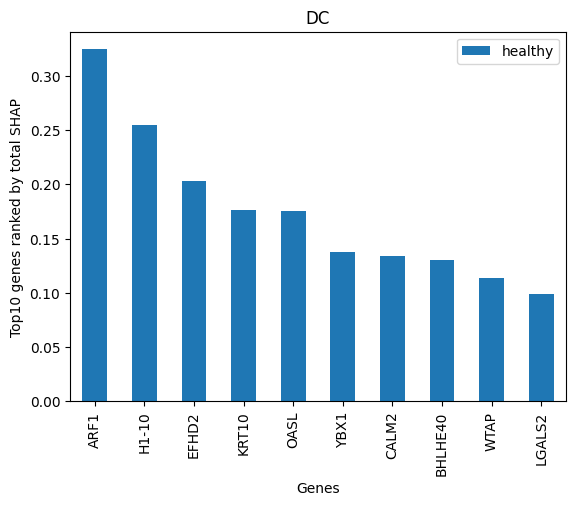

<Figure size 1500x1000 with 0 Axes>

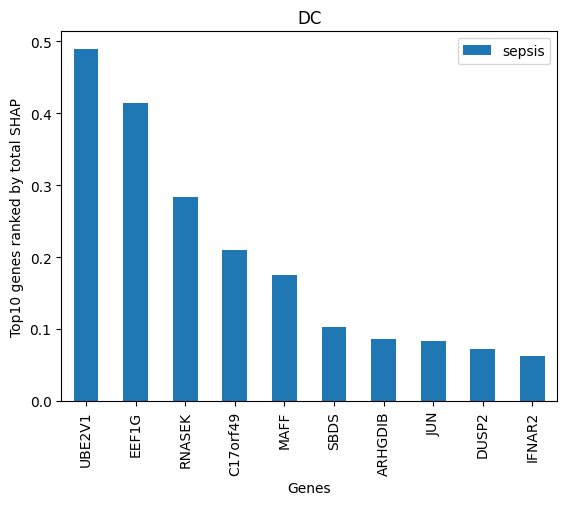

<Figure size 1500x1000 with 0 Axes>

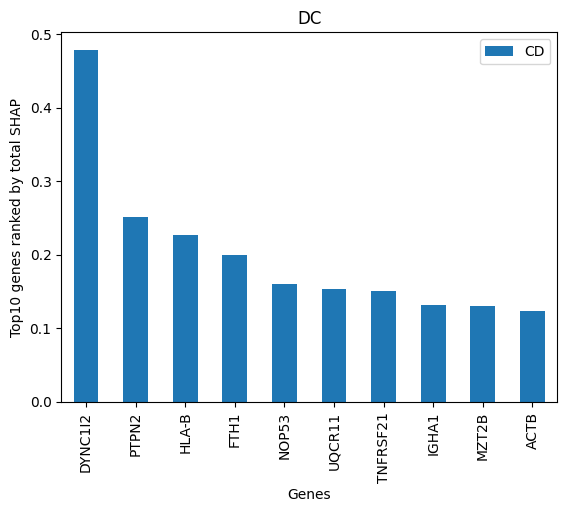

<Figure size 1500x1000 with 0 Axes>

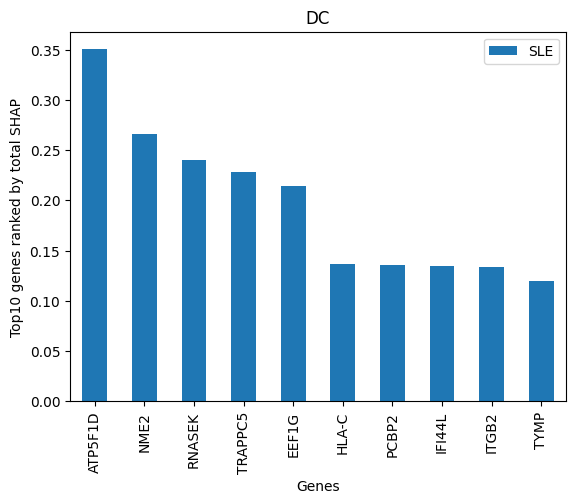

<Figure size 1500x1000 with 0 Axes>

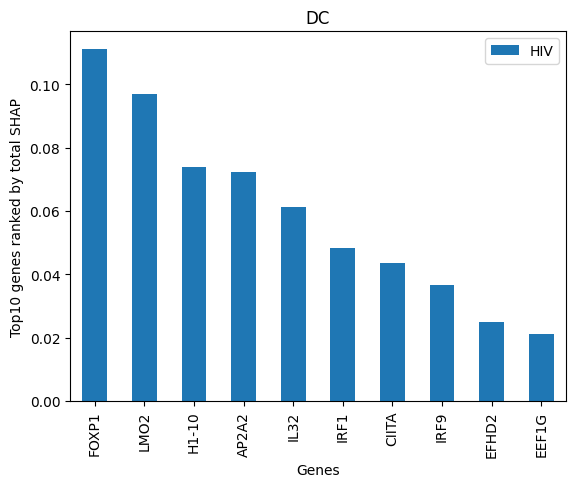

<Figure size 1500x1000 with 0 Axes>

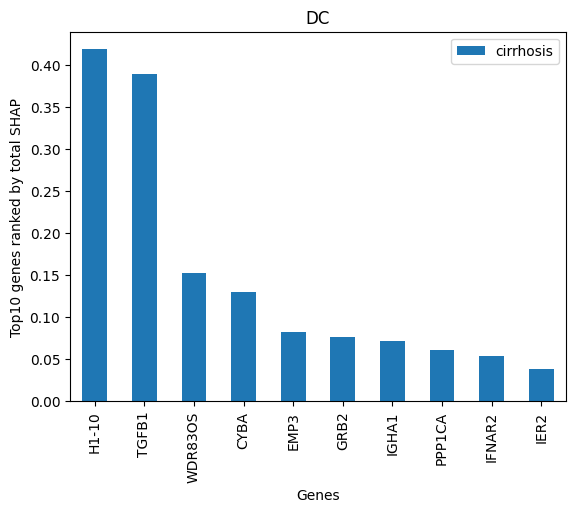

<Figure size 1500x1000 with 0 Axes>

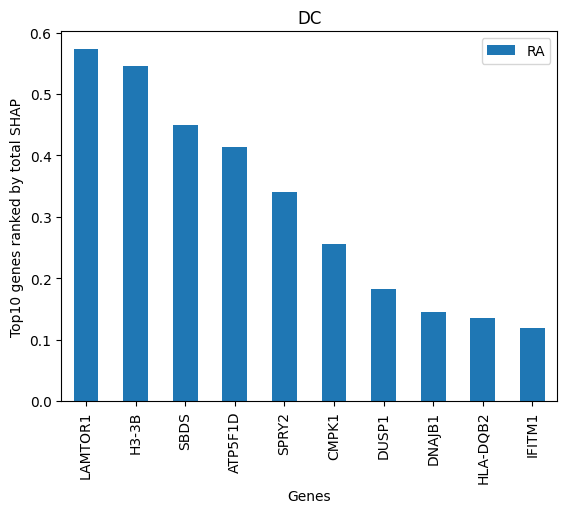

<Figure size 1500x1000 with 0 Axes>

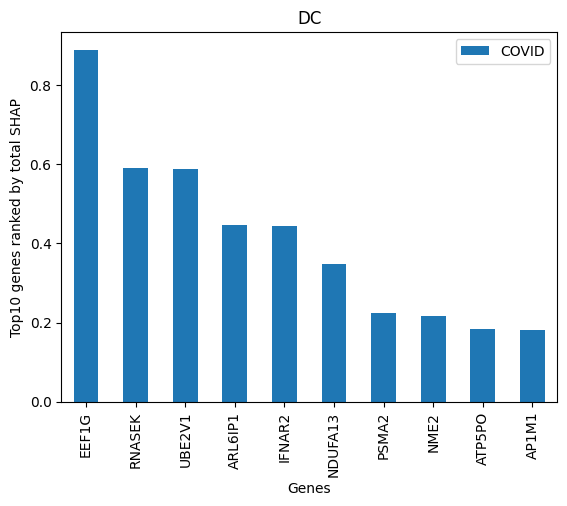

In [112]:
for cell_type in CELL_TYPES:
    for disease in DISEASES:
        array = top10_shap_values_per_cell_type[cell_type][disease]
        
        plt.figure(figsize = (15,10))
        array.plot(kind='bar', colormap='tab20')
        plt.title(cell_type)
        plt.ylabel('Top10 genes ranked by total SHAP')
        plt.xlabel('Genes')
        plt.show() 